In this notebook, we are also running `tractor` with forced photometry. First, we run `tractor` on the `i-band` images as per the blob-by-blob prescription in the `legacypipe`. Then we pass the model parameters such as position, shape, and Sersic index to initialize `tractor` in the other bands.

In [2]:
# import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy.utils.data import download_file, clear_download_cache
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import wcs


import kuaizi
from kuaizi.tractor.utils import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import tractor_blob_by_blob
from kuaizi.download import download_decals_cutout
from kuaizi.tractor.utils import getTargetProperty
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF 

import pickle
from IPython.display import clear_output

import tractor

In [3]:
# print version
kuaizi.__version__

'0.1.dev109+g054975f'

# **Focusing on one ladybug...**

In [4]:
## first, let's focus on one of the ladybug galaxies... 

# load catalog (to get the object information)
obj_cat = Table.read(
    '/home/diana/Research/ladybug_tractor/ladybug/ladybug-2021-03-03.fits'
    )

number = '1'

# match ladybug name
index = np.where(obj_cat['name'] == 'ladybug_'+number+'_y')[0][0]

print(
    'The fits file contains the following identifying information:\n', 
    obj_cat[index]
    )

The fits file contains the following identifying information:
     name                            prefix                                ra               dec               radius      
                                                                                                             arcsec      
----------- ------------------------------------------------------ ---------------- ------------------ ------------------
ladybug_1_y /tigress/MERIAN/poststamps/ladybug/1/1/hsc/ladybug_1_y 149.601282768496 1.6225202529022225 12.698968926649123


In [5]:
# initialize channels
ref_channel = ['i']
channels = ['i', 'N708']
forced_channels = ['N708']

# initialize ladybug 
obj = obj_cat[index]
obj_name = obj['name'].rstrip('_y')
obj_id = obj_name.lstrip('ladybug_')

# obtain coordinates of ladybug
coord = SkyCoord(obj['ra'], obj['dec'], frame = 'icrs', unit = 'deg')

In [16]:
# create list of cutouts and psfs of ladybug
cutout_hsc = [
    fits.open(
        f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}.fits'
    ) for filt in ref_channel]

cutout_merian = [fits.open(
        f'/home/diana/Research/{forced_channels[0]}/ladybug/{obj_id}/ladybug_{obj_id}_wide_{forced_channels[0]}.fits'
              )]

# variance (ie for weights)
var_merian = fits.open(
        f'/home/diana/Research/{forced_channels[0]}/ladybug/{obj_id}/w_ladybug_{obj_id}_wide_{forced_channels[0]}.fits'
              )

psf_list_hsc = [
    fits.open(
        f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}_psf.fits'
    ) for filt in ref_channel
]
psf_list_merian = [fits.open(
        f'/home/diana/Research/{forced_channels[0]}/ladybug/{obj_id}/ladybug_{obj_id}_wide_{forced_channels[0]}_psf.fits'
                )]
psf_list_all = np.append(psf_list_hsc, psf_list_merian)

In [17]:
# images and wcs
images_hsc = np.array([hdu[1].data for hdu in cutout_hsc])
images_merian = np.array([hdu[0].data for hdu in cutout_merian]) # data is stored elsewhere for Merian
images_all = np.append(images_hsc, images_merian)

w_hsc = np.array([wcs.WCS(hdu[1].header) for hdu in cutout_hsc]) 
w_merian = np.array([wcs.WCS(hdu[0].header) for hdu in cutout_merian])
w_all = np.append(w_hsc, w_merian) # not all bands share the same WCS!

### `ladybug_1` i-band
    Detected 15 objects
# Total number of objects: 15
# Central object index in i-band: 0
# Progress: 0 / 15
# Progress: 1 / 15
# Progress: 2 / 15
# Progress: 3 / 15
# Progress: 4 / 15
# Progress: 5 / 15
# Progress: 6 / 15
# Progress: 7 / 15
# Progress: 8 / 15
# Progress: 9 / 15
# Progress: 10 / 15
# Progress: 11 / 15
# Progress: 12 / 15
# Progress: 13 / 15
# Progress: 14 / 15


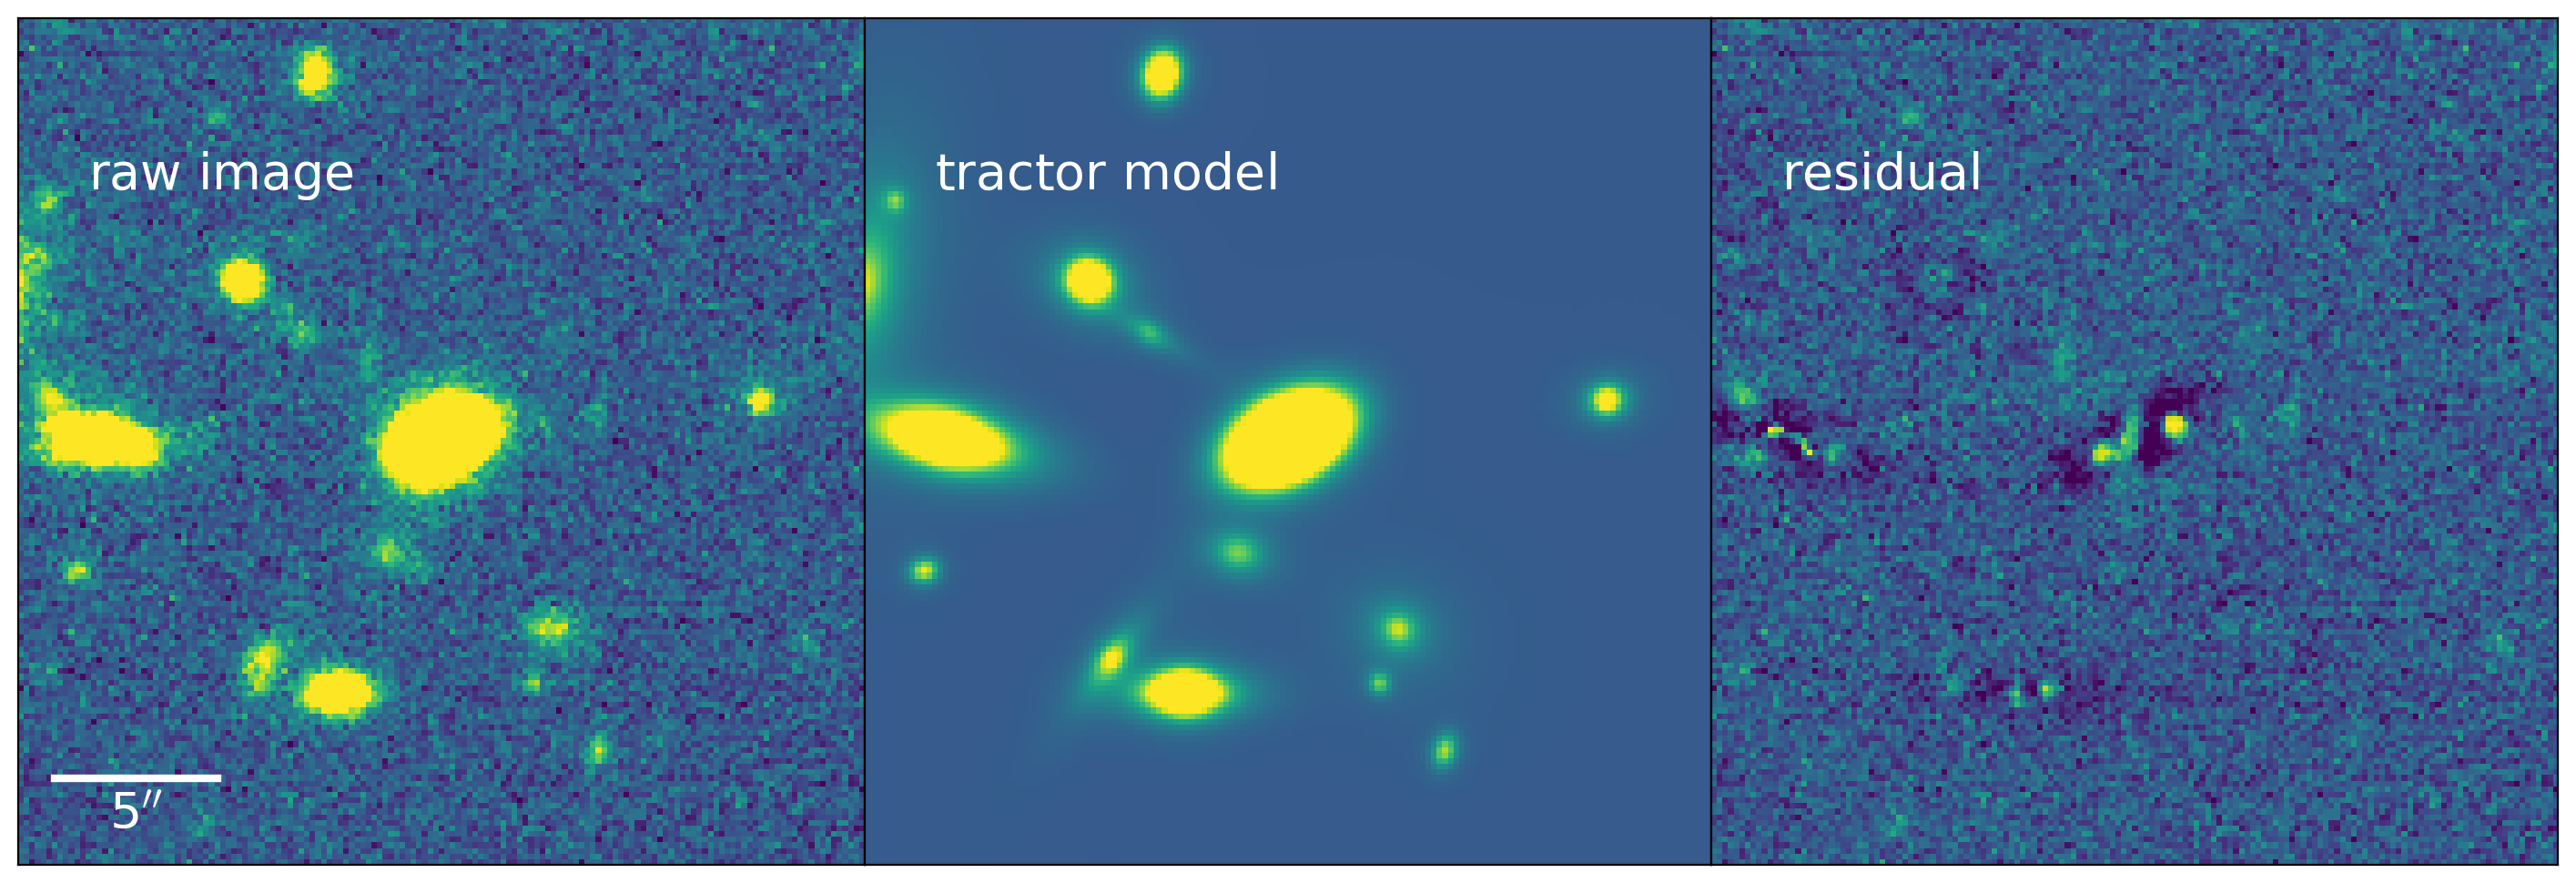

   The chi-square is 28194.111
SersicGalaxy at pixel (75.05, 75.42) with Flux: 412.473 and Galaxy Shape: re=1.05, ab=0.55, phi=116.9, Sersic index 0.747


KeyError: 'type'

In [63]:
# reconstruct ladybug data using kuaizi #
forced_filters = forced_channels[0] #N708

# weights for hsc sep
weights_hsc = 1 / np.array([hdu[3].data for hdu in cutout_hsc])

# weights for merian 
weights_merian = 1 / np.array(var_merian[0].data)

# psf paddin
psf_pad_hsc = padding_PSF(psf_list_hsc)
psf_pad_merian = padding_PSF(psf_list_merian)
#psf_pad_all = padding_PSF(psf_list_all) # is this needed since they are different psfs entirely?
data_hsc = Data(images=images_hsc, weights=weights_hsc, wcs=w_hsc[0], psfs=psf_pad_hsc, channels=channels)
data_merian = Data(images = images_merian, weights = weights_merian, wcs = w_merian, psfs = psf_pad_merian, channels = forced_channels)

# start fitting in the i-band first, then pass the i-band parameters of target 
# galaxy to other bands
ref_filt = ref_channel[0] # reference channel, ie i-band

model_dict = {}

model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(obj, ref_filt, channels, data_hsc, 
                                       freeze_dict = {'pos': True, 'shape': False, 'sersicindex': False}, 
                                       verbose=True)

sources_dict = {}
fig_dict = {}
# forced photometry in Merian band #
# initiate tractor psf object
psf_tractor_merian = tractor.psf.PixelizedPSF(psf_pad_merian[0]) 

# this function is actually called in tractor_hsc_sep_blob_by_blob
for count, filt in enumerate(forced_channels): 
    sources_dict[filt], model_dict[filt], fig_dict[filt] = tractor_blob_by_blob(obj_cat, w_merian, images_merian[0],
                                            invvar = weights_merian, 
                                            psf_obj = psf_tractor_merian, 
                                            pixel_scale = 0.01, # arbitratily assigned for testing script
                                            freeze_dict = {'pos': True, 'shape': True, 'sersicindex': True},
                                            ref_source=model_dict[ref_filt][0].catalog[model_dict[ref_filt][0].target_ind],
                                            verbose = True
                                           ) 

#for count, filt in enumerate(forced_channels): 
#    model_dict[filt] = tractor_hsc_sep_blob_by_blob(obj, ref_filt, channels, data_merian, 
#                                       freeze_dict = {'pos': True, 'shape': True, 'sersicindex': True}, 
#                                       verbose=True)

properties = {}

for filt in channels:
    properties[filt] = getTargetProperty(model_dict[filt], wcs=data.wcs)

catalog = {}

for key in [
    'ra', 'dec', 'x', 'y', 'flux', 're', 'ab', 'phi', 'sersic', 'type', 
    'ra_ivar', 'dec_ivar', 'x_ivar', 'y_ivar', 'flux_ivar', 're_ivar',
    'ab_ivar', 'phi_ivar', 'sersic_ivar']:
    catalog[f'{key}'] = np.array([properties[filt][key] for filt in channels])
print(catalog)

dicts = [model_dict, catalog]

# save dictionaries into a pickle
with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
    pickle.dump(dicts, f)


return model_dict

### `ladybug_1` i-band
    Detected 15 objects
# Total number of objects: 15
# Central object index in i-band: 0
# Progress: 0 / 15
# Progress: 1 / 15
# Progress: 2 / 15
# Progress: 3 / 15
# Progress: 4 / 15
# Progress: 5 / 15
# Progress: 6 / 15
# Progress: 7 / 15
# Progress: 8 / 15
# Progress: 9 / 15
# Progress: 10 / 15
# Progress: 11 / 15
# Progress: 12 / 15
# Progress: 13 / 15
# Progress: 14 / 15


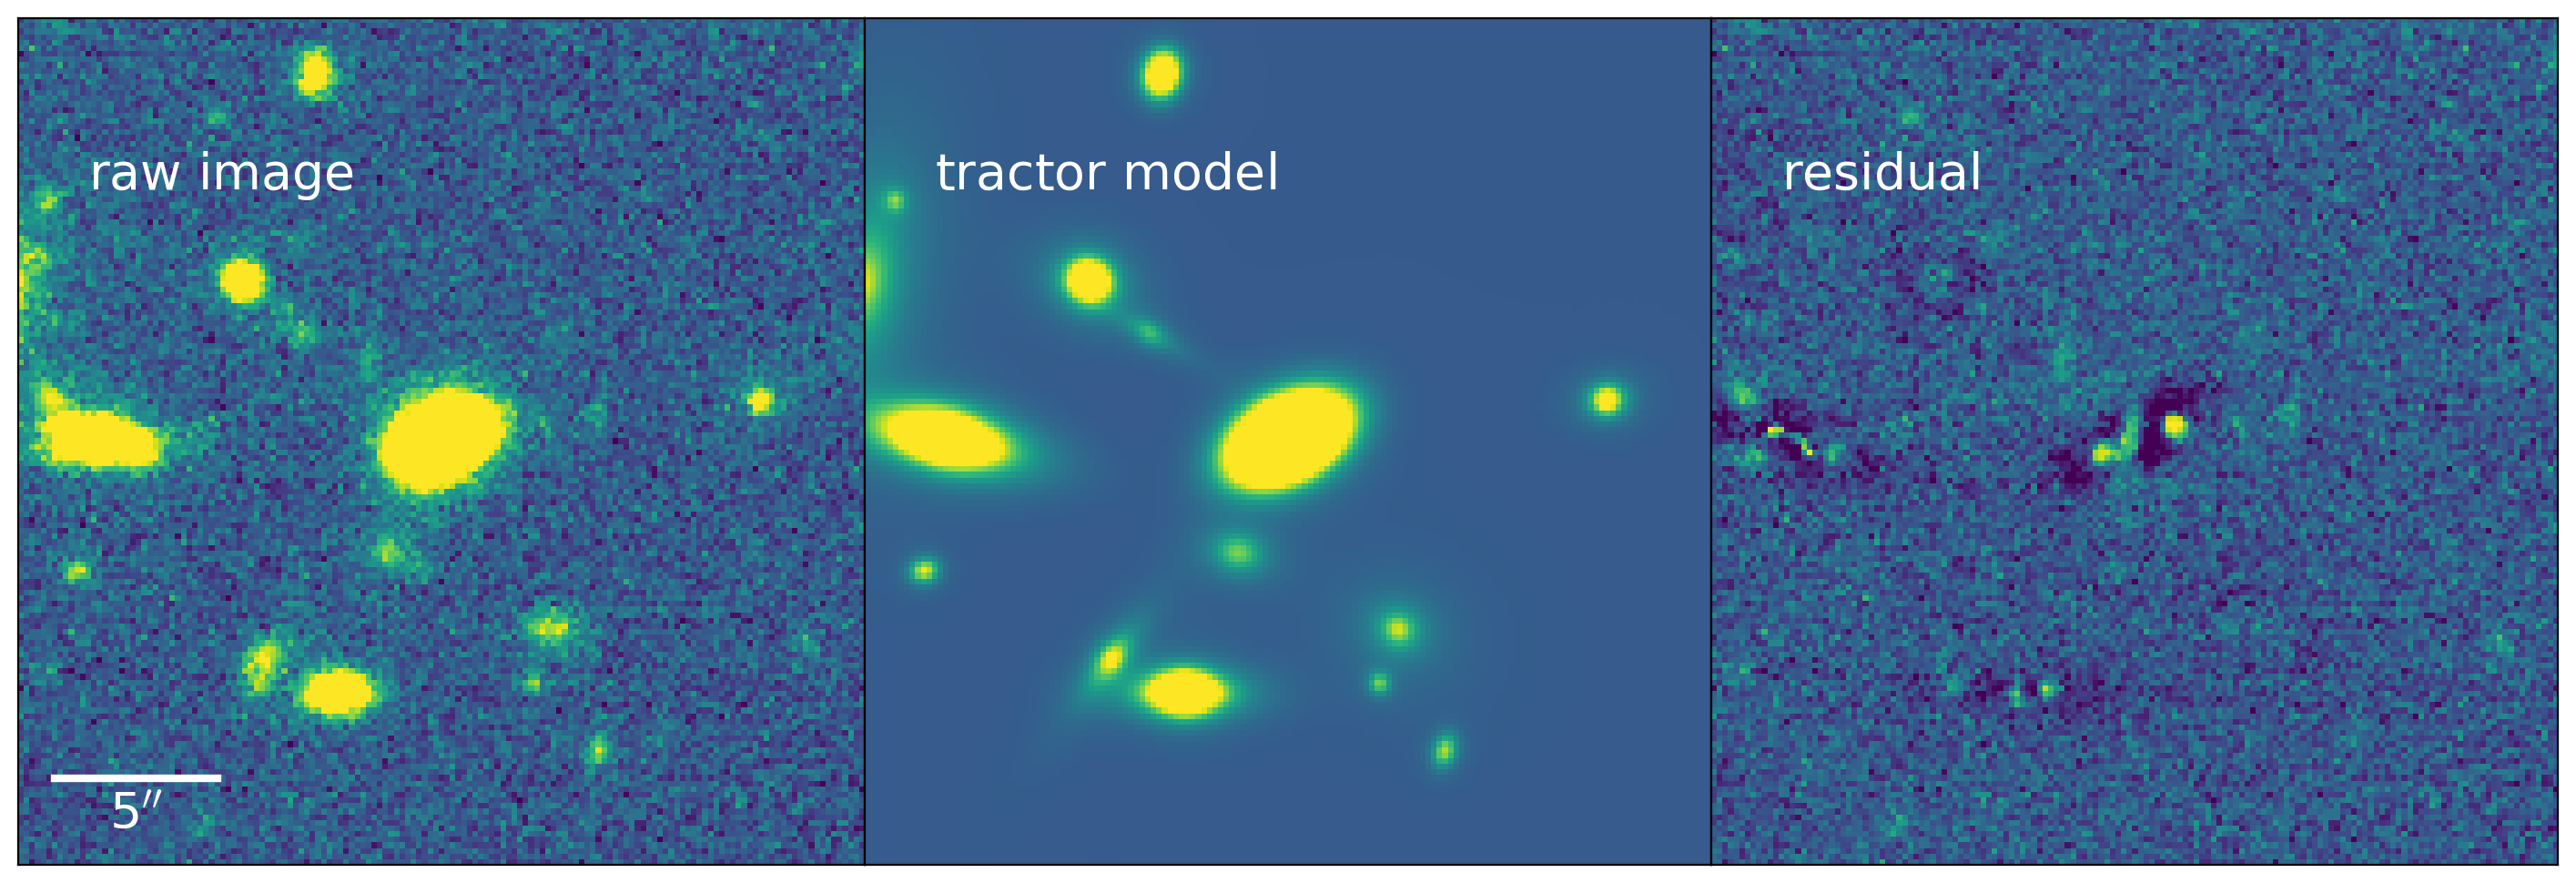

   The chi-square is 28194.111
SersicGalaxy at pixel (75.05, 75.42) with Flux: 412.473 and Galaxy Shape: re=1.05, ab=0.55, phi=116.9, Sersic index 0.747
### `ladybug_1` i-band
    Detected 5 objects


AttributeError: 'numpy.ndarray' object has no attribute 'wcs_pix2world'

In [64]:
# reconstruct ladybug data using kuaizi #
forced_filters = forced_channels[0] #N708

# weights for hsc sep
weights_hsc = 1 / np.array([hdu[3].data for hdu in cutout_hsc])

# weights for merian 
weights_merian = 1 / np.array(var_merian[0].data)

# psf paddin
psf_pad_hsc = padding_PSF(psf_list_hsc)
psf_pad_merian = padding_PSF(psf_list_merian)
#psf_pad_all = padding_PSF(psf_list_all) # is this needed since they are different psfs entirely?
data_hsc = Data(images=images_hsc, weights=weights_hsc, wcs=w_hsc[0], psfs=psf_pad_hsc, channels=channels)
data_merian = Data(images = images_merian, weights = weights_merian, wcs = w_merian, psfs = psf_pad_merian, channels = forced_channels)

# start fitting in the i-band first, then pass the i-band parameters of target 
# galaxy to other bands
ref_filt = ref_channel[0] # reference channel, ie i-band

model_dict = {}

model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(obj, ref_filt, channels, data_hsc, 
                                       freeze_dict = {'pos': True, 'shape': False, 'sersicindex': False}, 
                                       verbose=True)

sources_dict = {}
fig_dict = {}
# forced photometry in Merian band #
# initiate tractor psf object
psf_tractor_merian = tractor.psf.PixelizedPSF(psf_pad_merian[0]) 

# this function is actually called in tractor_hsc_sep_blob_by_blob
#for count, filt in enumerate(forced_channels): 
#    sources_dict[filt], model_dict[filt], fig_dict[filt] = tractor_blob_by_blob(obj_cat, w_merian, images_merian[0],
#                                            invvar = weights_merian, 
#                                            psf_obj = psf_tractor_merian, 
#                                            pixel_scale = 0.01, # arbitratily assigned for testing script
#                                            freeze_dict = {'pos': True, 'shape': True, 'sersicindex': True},
#                                            ref_source=model_dict[ref_filt][0].catalog[model_dict[ref_filt][0].target_ind],
#                                            verbose = True
#                                           ) 

for count, filt in enumerate(forced_channels): 
    model_dict[filt] = tractor_hsc_sep_blob_by_blob(obj, ref_filt, channels, data_merian, 
                                       freeze_dict = {'pos': True, 'shape': True, 'sersicindex': True}, 
                                       verbose=True)

properties = {}

for filt in channels:
    properties[filt] = getTargetProperty(model_dict[filt], wcs=data.wcs)

catalog = {}

for key in [
    'ra', 'dec', 'x', 'y', 'flux', 're', 'ab', 'phi', 'sersic', 'type', 
    'ra_ivar', 'dec_ivar', 'x_ivar', 'y_ivar', 'flux_ivar', 're_ivar',
    'ab_ivar', 'phi_ivar', 'sersic_ivar']:
    catalog[f'{key}'] = np.array([properties[filt][key] for filt in channels])
print(catalog)

dicts = [model_dict, catalog]

# save dictionaries into a pickle
with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
    pickle.dump(dicts, f)


return model_dict

In [61]:
### what is this error? 
datas = [data_merian]
if len(datas) == 1:
    ra, dec = datas[0].wcs[0].wcs_pix2world()

# this looks like it works (of course, I do not pass any arguments because in 
# the original kuaizi.tractor.utils, the arguments are created in makeCatalog)

TypeError: WCS projection has 2 dimensions, so expected 2 (an Nx2 array and the origin argument) or 3 arguments (the position in each dimension, and the origin argument). Instead, 0 arguments were given.